# Wheat Protein（none-process）

Using device: cuda


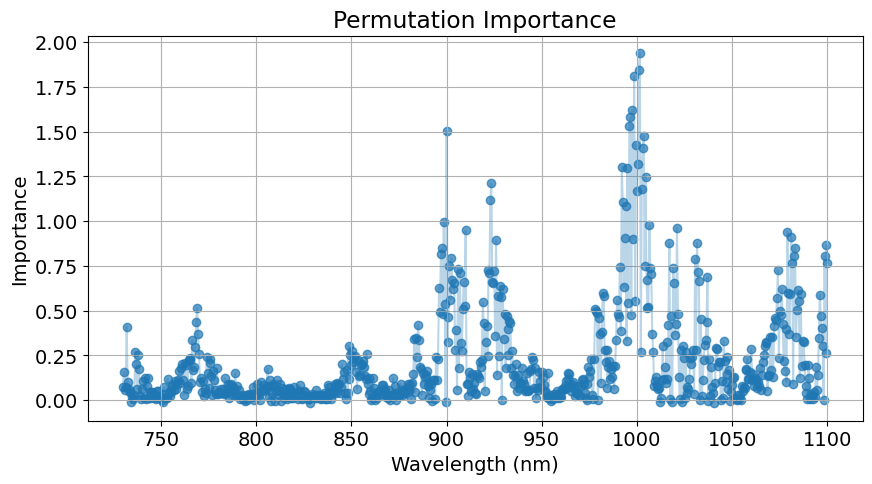

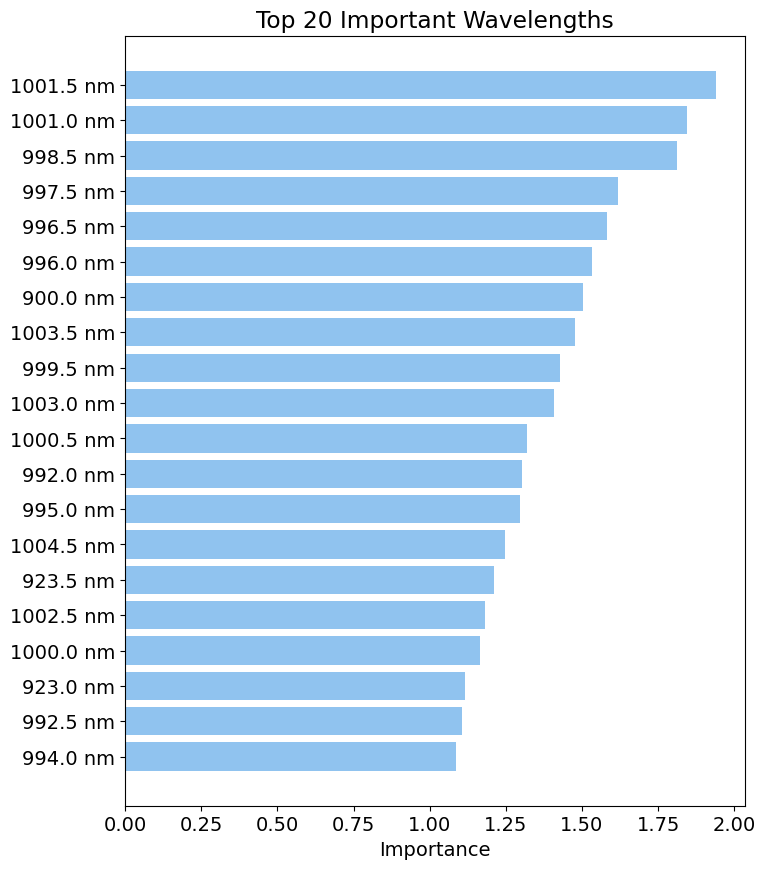

In [1]:
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split
from tabpfn import TabPFNRegressor
plt.rcParams.update({'font.size': 14})

# =============================
#  Device
# =============================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

os.environ.setdefault("TABPFN_MODEL_CACHE_DIR", r"D:\workspace\TabPFN\tabpfn")

# =============================
#  Load TabPFN
# =============================
def load_tabpfn():
    model_path = os.path.join(
        os.environ["TABPFN_MODEL_CACHE_DIR"],
        "tabpfn-v2.5-regressor-v2.5_real.ckpt"
    )
    
    model = TabPFNRegressor(
        model_path=model_path,
        device=device,
        random_state=42
    )
    setattr(model, "ignore_pretraining_limits", True)
    return model

# =============================
#  Load Data
# =============================
data_path = "D:/A/CSU/NIRdatasets/wheat/Cal_ManufacturerA1.xlsx"
df = pd.read_excel(data_path)

spectra = df.iloc[:, 2:743].values
y = df.iloc[:, 1].values

wavelengths = pd.to_numeric(df.columns[2:743], errors='coerce').to_numpy()

# =============================
#  Train-test split
# =============================
X_train, X_test, y_train, y_test = train_test_split(spectra, y, test_size=0.2, random_state=42)
# =============================
#  TabPFN Model
# =============================
model = load_tabpfn()
model.fit(X_train, y_train)
y_pred_base = model.predict(X_test)

# =============================
#  Permutation Importance
# =============================
def permutation_importance(model, X_test, y_test):
    """
    For each wavelength, randomly shuffle the wavelengths and calculate the change in RMSE sequentially.
    The greater the increase in RMSE, the more important the wavelength.
    """
    base_rmse = np.sqrt(np.mean((y_test - model.predict(X_test))**2))
    importances = np.zeros(X_test.shape[1])

    X_temp = X_test.copy()
    
    for i in range(X_test.shape[1]):
        X_perm = X_temp.copy()
        np.random.shuffle(X_perm[:, i])  # Shuffle a single feature
        
        y_perm = model.predict(X_perm)
        rmse_perm = np.sqrt(np.mean((y_test - y_perm)**2))
        
        importances[i] = rmse_perm - base_rmse  # Increase in RMSE
    
    return importances

importances = permutation_importance(model, X_test, y_test)


plt.figure(figsize=(10, 5))
plt.scatter(wavelengths, importances, alpha=0.7)
plt.plot(wavelengths, importances, alpha=0.3)

plt.title("Permutation Importance")
plt.xlabel("Wavelength (nm)")
plt.ylabel("Importance")
plt.grid(True)
plt.show()

#  bar plot
sorted_idx = np.argsort(importances)[::-1]

plt.figure(figsize=(8, 10))
plt.barh(
    [f"{wavelengths[i]} nm" for i in sorted_idx[:20]],
    importances[sorted_idx[:20]],color="#90c3ef")

plt.title("Top 20 Important Wavelengths")
plt.xlabel("Importance")
plt.gca().invert_yaxis()
plt.show()


# Corn Protein （process）

Using device: cuda


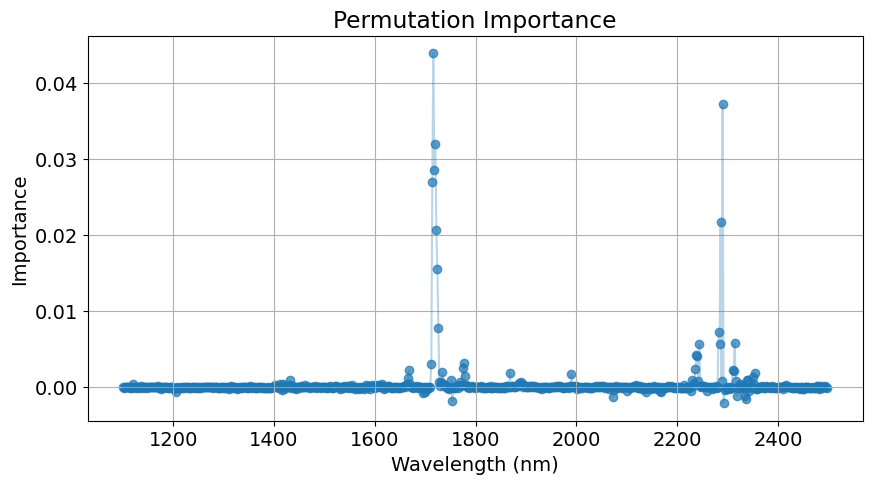

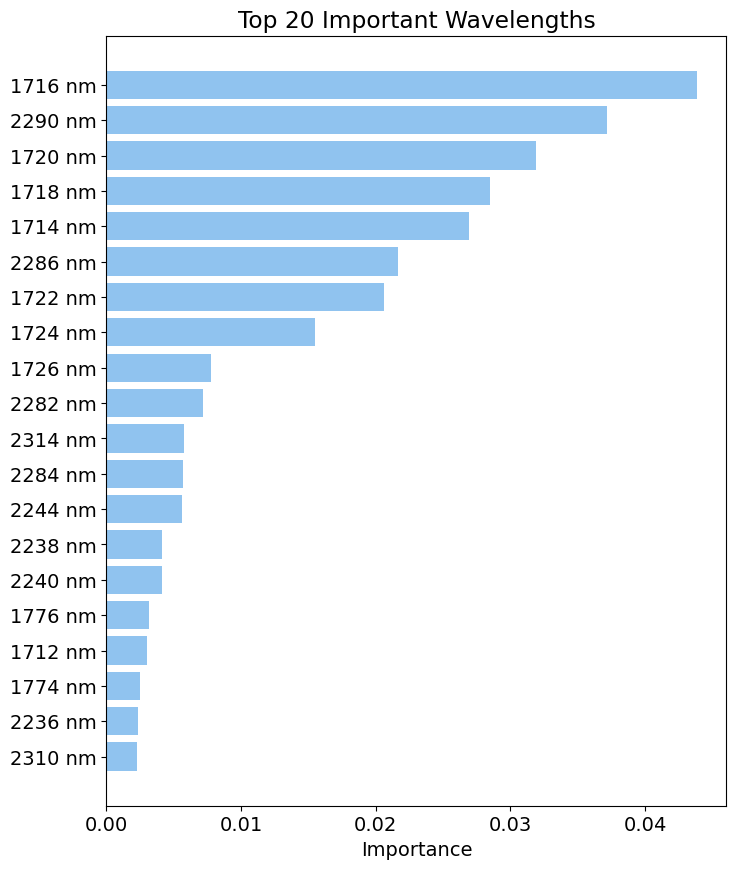

In [3]:
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split
from tabpfn import TabPFNRegressor
plt.rcParams.update({'font.size': 14})
from preprocessing.process import derivative
# =============================
#  Device
# =============================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

os.environ.setdefault("TABPFN_MODEL_CACHE_DIR", r"D:\workspace\TabPFN\tabpfn")

# =============================
#  Load TabPFN
# =============================
def load_tabpfn():
    model_path = os.path.join(
        os.environ["TABPFN_MODEL_CACHE_DIR"],
        "tabpfn-v2.5-regressor-v2.5_real.ckpt"
    )
    
    model = TabPFNRegressor(
        model_path=model_path,
        device=device,
        random_state=42
    )
    setattr(model, "ignore_pretraining_limits", True)
    return model

# =============================
#  Load Data
# =============================
data_path = "D:/A/CSU/NIRdatasets/corn_xlsl/m5_corn.xlsx"
df = pd.read_excel(data_path)
spectra = df.iloc[:, :700].values
y = df.iloc[:, 701].values

wavelengths = pd.to_numeric(df.columns[:700], errors='coerce').to_numpy()

# =============================
#  Train-test split
# =============================
X_train, X_test, y_train, y_test = train_test_split(spectra, y, test_size=0.2, random_state=42)

# =============================
#  process
# =============================

X_train = derivative(X_train)
X_test = derivative(X_test)

# =============================
#  TabPFN Model
# =============================
model = load_tabpfn()
model.fit(X_train, y_train)
y_pred_base = model.predict(X_test)

# =============================
#  Permutation Importance
# =============================
def permutation_importance(model, X_test, y_test):
    """
    For each wavelength, randomly shuffle the wavelengths and calculate the change in RMSE sequentially.
    The greater the increase in RMSE, the more important the wavelength.
    """
    base_rmse = np.sqrt(np.mean((y_test - model.predict(X_test))**2))
    importances = np.zeros(X_test.shape[1])

    X_temp = X_test.copy()
    
    for i in range(X_test.shape[1]):
        X_perm = X_temp.copy()
        np.random.shuffle(X_perm[:, i])  # Shuffle a single feature
        
        y_perm = model.predict(X_perm)
        rmse_perm = np.sqrt(np.mean((y_test - y_perm)**2))
        
        importances[i] = rmse_perm - base_rmse  # Increase in RMSE
    
    return importances

importances = permutation_importance(model, X_test, y_test)


plt.figure(figsize=(10, 5))
plt.scatter(wavelengths, importances, alpha=0.7)
plt.plot(wavelengths, importances, alpha=0.3)

plt.title("Permutation Importance")
plt.xlabel("Wavelength (nm)")
plt.ylabel("Importance")
plt.grid(True)
plt.show()

#  bar plot
sorted_idx = np.argsort(importances)[::-1]

plt.figure(figsize=(8, 10))
plt.barh(
    [f"{wavelengths[i]} nm" for i in sorted_idx[:20]],
    importances[sorted_idx[:20]],color="#90c3ef")

plt.title("Top 20 Important Wavelengths")
plt.xlabel("Importance")
plt.gca().invert_yaxis()
plt.show()